# Volcanic Eruptions - Exploratory Data Analysis

## Setup

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import compress

In [2]:
# Import sys library and project src
import sys

sys.path.append('..')

## Utility functions
from src.data.utils import ts_crust_type_to_cat

In [3]:
# project root
here = "../"

# read data
eruptions = pd.read_csv(here + 'data/processed/eruptions.csv')
eruptions = ts_crust_type_to_cat(eruptions)

In [4]:
eruptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 1503 non-null   int64   
 1   name               1503 non-null   object  
 2   region             1503 non-null   object  
 3   country            1503 non-null   object  
 4   lon                1503 non-null   float64 
 5   lat                1503 non-null   float64 
 6   elevation          1503 non-null   int64   
 7   type               1500 non-null   object  
 8   dominant_rock      1393 non-null   object  
 9   ts_zone            1495 non-null   object  
 10  ts_crust_type      1412 non-null   category
 11  last_eruption_bp   868 non-null    float64 
 12  activity_evidence  1502 non-null   object  
dtypes: category(1), float64(3), int64(2), object(7)
memory usage: 142.6+ KB


## Exploratory Analysis

In [5]:
eruptions[['elevation', 'last_eruption_bp']].describe()

,elevation,last_eruption_bp
count,1503.000000,868.000000
mean,1683.351963,1174.665899
std,1572.804970,2325.414519
min,-4200.000000,-66.000000
25%,686.500000,-47.250000
50%,1460.000000,44.500000
75%,2353.500000,1100.000000
max,6879.000000,12399.000000


### Plot distribution of last eruptions:

In [110]:
"""
Use functions to control histogram binwidths directly - solution from
https://stackoverflow.com/questions/6986986/bin-size-in-matplotlib-histogram
(requires separate functions for int and float data types)
"""

def hist_binwidth_to_bins_int(data, binwidth):
    return range(min(data), max(data) + binwidth, binwidth)

def hist_binwidth_to_bins_flt(data, binwidth):
    return np.arange(min(data), max(data) + binwidth, binwidth)

Volcano last eruption dates heavily skewed towards the last 1000 years bp:

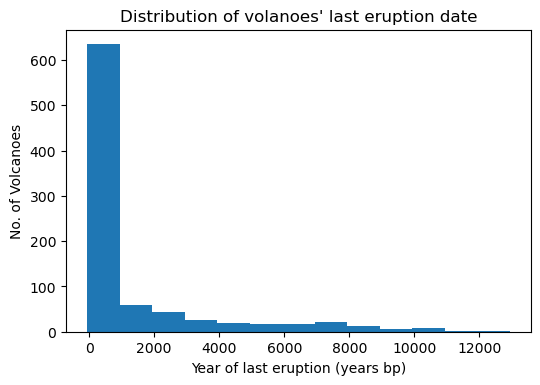

In [111]:
# Histogram of all last_eruption_bp values, binwidth = 1000 years

fig_last_eruption_hist, ax_last_eruption_hist = plt.subplots(1, 1, dpi = 100)
ax_last_eruption_hist.hist(
    x = eruptions['last_eruption_bp'], 
    bins = hist_binwidth_to_bins_flt(
        data =eruptions['last_eruption_bp'], 
        binwidth = 1000
    )
)

ax_last_eruption_hist.set_xlabel("Year of last eruption (years bp)")
ax_last_eruption_hist.set_ylabel("No. of Volcanoes")
ax_last_eruption_hist.set_title("Distribution of volanoes' last eruption date")
plt.show()

Eruptions within 1000 years bp are further skewed towards dates that are
actually *after* bp (1950):

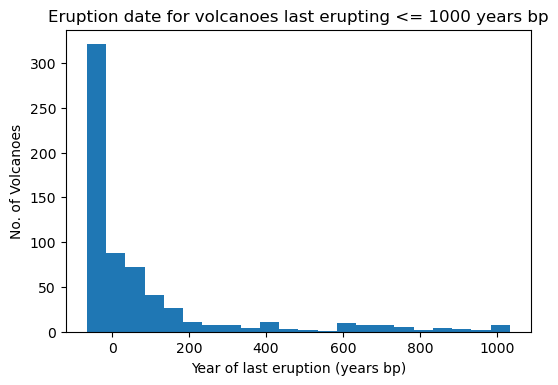

In [39]:
# Explore distribution of eruptions in last 1000 years
most_recent_eruptions = eruptions.query('last_eruption_bp <= 1000')

fig_last_eruption_hist_1000, ax_last_eruption_hist_1000 = plt.subplots(1, 1, dpi = 100)
ax_last_eruption_hist_1000.hist(
    x = most_recent_eruptions['last_eruption_bp'], 
    bins = hist_binwidth_to_bins_flt(
        data = most_recent_eruptions['last_eruption_bp'], 
        binwidth = 50
    )
)

ax_last_eruption_hist_1000.set_xlabel("Year of last eruption (years bp)")
ax_last_eruption_hist_1000.set_ylabel("No. of Volcanoes")
ax_last_eruption_hist_1000.set_title("Eruption date for volcanoes last erupting <= 1000 years bp")
plt.show()

This distribution might be partly explained by bias in the availability of 
activity evidence. There is clear reliance on direct observation of eruptions,
followed by 'Eruption Dating' which is probably a mixture of historical record or
scientific dating. Naturally, the further back in time the last event that might
provide activity evidence occurred, the harder that evidence will be to observe
and date, and the lower the probability of identifying the volcano in the first
place.

Text(0, 0.5, 'Activity Evidence')

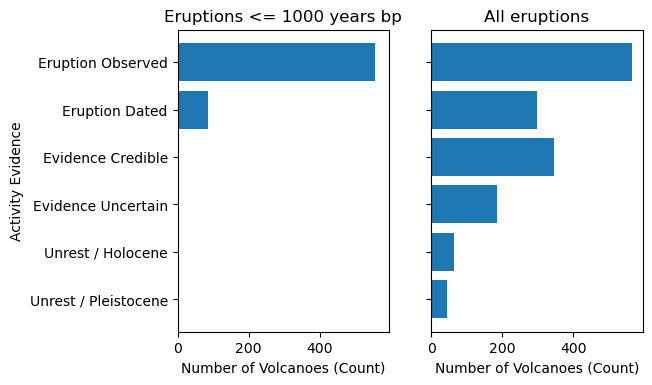

In [112]:
# Counts of eruptions by evidence
most_rcnt_eruptions_cnt_by_ev = (
    most_recent_eruptions
    .groupby(most_recent_eruptions.activity_evidence, as_index = False)
    .size()
    .sort_values('size', ascending = False)
    .reset_index(drop = True)
)
all_eruptions_cnt_by_ev = (
    eruptions
    .groupby(eruptions.activity_evidence, as_index = False)
    .size()
    .sort_values('size', ascending = False)
    .reset_index(drop = True)
)

fig_eruptions_by_evidence, (ax1, ax2) = plt.subplots(1, 2, dpi = 100, sharey = True, sharex = True)

ax1.barh(
    most_rcnt_eruptions_cnt_by_ev.activity_evidence, 
    width = most_rcnt_eruptions_cnt_by_ev['size']
)
ax2.barh(
    all_eruptions_cnt_by_ev.activity_evidence, 
    width = all_eruptions_cnt_by_ev['size']
)
ax2.invert_yaxis()
ax1.set_title("Eruptions <= 1000 years bp")
ax2.set_title("All eruptions")
ax1.set_xlabel("Number of Volcanoes (Count)")
ax2.set_xlabel("Number of Volcanoes (Count)")
ax1.set_ylabel("Activity Evidence")

Related sampling bias might be observable in the distribution of elevation 
against last eruption date. The vast majority of volcanoes in the dataset
are above sea-level, probably reflecting accessability - volcanoes on land
are easier to identify and survey. 

Text(0.5, 1.0, 'Dates of last known eruptions (bp) against volcano elevation')

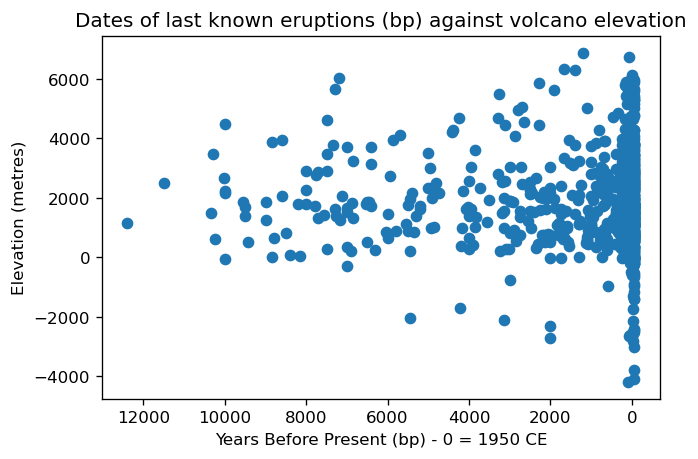

In [157]:
fig_last_by_elevation, ax_last_by_elevation = plt.subplots(1,1, dpi = 120)

# Scatter of Elevation against Last Eruption
ax_last_by_elevation.scatter(eruptions['last_eruption_bp'], eruptions['elevation'])
ax_last_by_elevation.invert_xaxis()
ax_last_by_elevation.set_xlabel("Years Before Present (bp) - 0 = 1950 CE")
ax_last_by_elevation.set_ylabel("Elevation (metres)")
ax_last_by_elevation.set_title("Dates of last known eruptions (bp) against volcano elevation")

It is also not surprising that of the volcanoes below or at sea-level (n = 133),
there are only 29 that last erupted before 1950. Of these, the deepest 
(< -1000 metres) all erupted after 6000 bp and all save one were from the Hawaii
and Pacific Ocean region. Volcanoes below sea level with a last eruption predating
6000 years bp were all less than 1000 metres below sea-level.

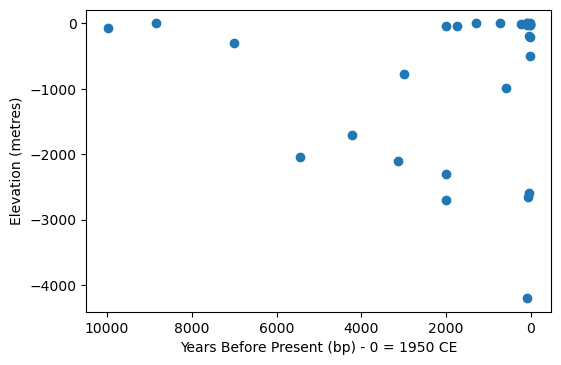

In [165]:
volcanoes_below_sea_level = (eruptions
 .query('elevation <= 0 and last_eruption_bp >= 0')
 .filter(['last_eruption_bp', 'elevation'])
 .sort_values(['elevation'])
)

fig_v_below_sl, ax_v_below_sl = plt.subplots(1,1, dpi=100)
ax_v_below_sl.scatter(
    x = volcanoes_below_sea_level.last_eruption_bp, 
    y = volcanoes_below_sea_level.elevation
)
ax_v_below_sl.set_xlabel("Years Before Present (bp) - 0 = 1950 CE")
ax_v_below_sl.set_ylabel("Elevation (metres)")
ax_v_below_sl.invert_xaxis()

In [163]:
eruptions.query('elevation <= -1000 and last_eruption_bp >= 10')

,id,name,region,country,lon,lat,elevation,type,dominant_rock,ts_zone,ts_crust_type,last_eruption_bp,activity_evidence
1039,331010,Endeavour Segment,Hawaii and Pacific Ocean,Canada,-129.10,47.950,-2050,Submarine,Basalt / Picro-Basalt,Rift Zone,Oceanic Crust,5439.0,Eruption Dated
1040,331011,Cobb Segment,Hawaii and Pacific Ocean,Canada,-129.33,46.880,-2100,Submarine,Basalt / Picro-Basalt,Rift Zone,Oceanic Crust,3129.0,Eruption Dated
1046,331040,Escanaba Segment,Hawaii and Pacific Ocean,Undersea Features,-127.50,40.980,-1700,Submarine,Basalt / Picro-Basalt,Rift Zone,Oceanic Crust,4209.0,Eruption Dated
1060,334020,Northern EPR-Segment RO2,Hawaii and Pacific Ocean,Undersea Features,-105.32,16.550,-2700,Submarine,Basalt / Picro-Basalt,Rift Zone,Oceanic Crust,1999.0,Eruption Dated
1061,334021,Northern EPR-Segment RO3,Hawaii and Pacific Ocean,Undersea Features,-105.43,15.830,-2300,Submarine,Basalt / Picro-Basalt,Rift Zone,Oceanic Crust,1999.0,Eruption Dated
1067,334130,Southern EPR-Segment J,Hawaii and Pacific Ocean,Undersea Features,-113.35,-18.175,-2650,Submarine,Basalt / Picro-Basalt,Rift Zone,Oceanic Crust,60.0,Eruption Dated
1068,334140,Southern EPR-Segment I,Hawaii and Pacific Ocean,Undersea Features,-113.42,-18.530,-2600,Submarine,Basalt / Picro-Basalt,Rift Zone,Oceanic Crust,35.0,Eruption Dated
1439,381040,Pico Fracture Zone,Atlantic Ocean,Undersea Features,-38.08,38.750,-4200,Submarine,NaN,Intraplate,Oceanic Crust,85.0,Eruption Observed


Almost all volcano types are exclusively above sea-level. Only 'Submarine' and
'Caldera' types have a significant presence below sea-level. Almost all
types have elevation distributions skewed to the right, with the majority of
outliers being above 4000 metres. Submarine volcanoes are the stand-out
exception, being left-skewed - again perhaps due to practical difficulties
of identifying and surveying underwater volcanoes, so naturally the deepest
ones are rarer.

It is probably the case that elevation is partially used to determine the type
of volcano by vulcanologists, so we can probably expect a weak positive
correlation between elevation and certain types.

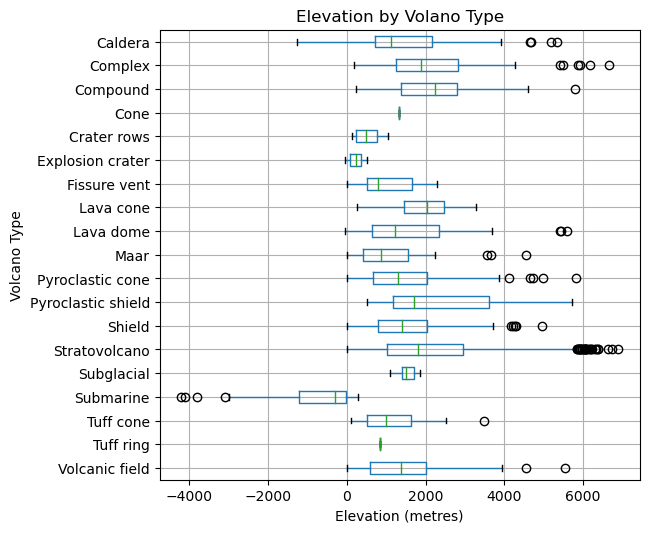

In [175]:
# Setup figure
fig_elevation_boxplot, ax_elevation_boxplot = plt.subplots(
    1, 1, sharey=False, sharex=False, dpi = 100,
    figsize = [6, 6]
)

# Boxplot of Elevation by Type
eruptions.boxplot(column = 'elevation', by = 'type', ax = ax_elevation_boxplot, vert=False)
ax_elevation_boxplot.set_ylabel("Volcano Type")
ax_elevation_boxplot.set_xlabel("Elevation (metres)")
ax_elevation_boxplot.set_title("Elevation by Volano Type")
ax_elevation_boxplot.invert_yaxis()
# ax2.tick_params(axis = 'x', labelrotation = 90, width = 0.5)

# Drop the global title set by boxplot
fig_elevation_boxplot.suptitle("")

plt.show()